# Data download

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2023-12-22 16:30:44--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.8MB/s    in 4.6s    

2023-12-22 16:30:49 (17.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


In [2]:
import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#Function to transform the IMDB dataset into train and test set taken from:
#https://github.com/shivakrishna2497/Sentiment-Analysis-of-IMDB-Movie-Reviews/blob/master/Untitled.ipynb
def load_train_test_imdb_data(data_dir):

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    print(data["test"])
    return data["train"], data["test"]

In [4]:
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

                                                    text  sentiment
0      Just after I saw the movie, the true magic fee...          1
1      This one is bad. A really bad and boring crime...          0
2      I don't usually write a comment when there are...          0
3      This really doesn't match up to Castle of Cagl...          0
4      It's a colorful slasher movie. That's about it...          1
...                                                  ...        ...
24995  This is the most depressing film I have ever s...          0
24996  I happened on "Shower" in the foreign film sec...          1
24997  Prolific and highly influential filmmaker Mart...          1
24998  This series, produced at probably the most pro...          1
24999  Here is one of those movies spoiled by the stu...          0

[25000 rows x 2 columns]
                                                    text  sentiment
0      The show is GREAT. No words to describe it. Wo...          1
1      As I said, some

In [5]:
#Preprocessing training data: setting everything to lowercase, 
#removing non-alphabetic characters, removing multiple spaces
train_data_pre = train_data['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
train_data_pre.apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
train_data_pre.apply(lambda x: re.sub(" +", " ", x))

#Removing english stop words
stop = stopwords.words("english")
train_data_pre.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

#Lemmatizing words
lemmatizer = WordNetLemmatizer()
train_data_pre.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

0        just after i saw the movie , the true magic fe...
1        this one is bad . a really bad and boring crim...
2        i do n't usually write a comment when there ar...
3        this really doe n't match up to castle of cagl...
4        it 's a colorful slasher movie . that 's about...
                               ...                        
24995    this is the most depressing film i have ever s...
24996    i happened on `` shower '' in the foreign film...
24997    prolific and highly influential filmmaker mart...
24998    this series , produced at probably the most pr...
24999    here is one of those movie spoiled by the stud...
Name: text, Length: 25000, dtype: object

In [6]:
#Repeating for test data
test_data_pre = test_data['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
test_data_pre.apply(lambda x: " ".join([re.sub("[^A-Za-z]+","", x) for x in nltk.word_tokenize(x)]))
test_data_pre.apply(lambda x: re.sub(" +", " ", x))

stop = stopwords.words("english")
test_data_pre.apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

lemmatizer = WordNetLemmatizer()
test_data_pre.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

0        the show is great . no word to describe it . w...
1        a i said , sometimes low budget is good . you ...
2        in landscape after the battle , andrzej wajda ...
3        tv churn out dozen of true-crime movie every y...
4        i love this movie . i watched it over and over...
                               ...                        
24995    i 'm a huge lover of really bad b movie . and ...
24996    this cartoon is not right , lol i totally disa...
24997    this is one of those movie that are very under...
24998    after the failure of `` hellraiser iii : hell ...
24999    i had the great pleasure of recently viewing t...
Name: text, Length: 25000, dtype: object

In [7]:
#Separating X and y from each other and converting y to a categorical variable 
#- required for Keras dense layers with softmax activation
X_train = train_data_pre
y_train = to_categorical(train_data['sentiment'], num_classes=2)
X_test = test_data_pre
y_test = to_categorical(test_data['sentiment'], num_classes=2)

seed=69420

In [8]:
#Function to display the history of accuracy throughout epochs 
def display_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Task 1: TF-IDF + classical model

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [ ]:
#Instatiating a TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer='word')

#Transforming train and test datasets based on fitting to the train dataset
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
#Instantiating and fitting a linear SVM on TF-IDF vectors
model_svm = LinearSVC()
model_svm.fit(X_train_tfidf, y_train)

#Calculating testing accuracy
y_pred_tfidf = model_svm.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred_tfidf))

0.8696


Conclusions:

For such a simple model as a linear SVM, which trains instantly, and required very little work to set up, the accuracy of ~87% is satisfying.

Linear SVM can be a good model for sentiment analysis if the vectors of different texts, when encoded, are linearly separable in n-th dimension.
In the case of this dataset it is clear that this is not the case, however the vectors are close enough to being linearly separable to give a decent testing accuracy.

As mentioned before, speed is the main advantage of the model, together with ease of tokenization, which is done nearly automatically.

The main disadvantage is the fact, that outside of better text preprocessing, not much can be done to improve the outcome of this particular model.



Task 2: LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [ ]:
#Instantiating and fitting a basic tokenizer for both train and valid data, 
#while taking into account only top 500 most common words, to speed up the training
tokenizer_train = Tokenizer(num_words=500)
tokenizer_train.fit_on_texts(X_train)
X_train_lstm = tokenizer_train.texts_to_sequences(X_train)
X_test_lstm = tokenizer_train.texts_to_sequences(X_test)

#Creating a word index for train tokenizer and checking length of train vocabulary
word_index_train = tokenizer_train.word_index
n_words_train = len(word_index_train)

#Repeating for test dataset - separate test tokenizer is instantiated 
#solely in order to obtain a separate .word_index object for test data
#It is not used to tokenize test data used in actual training
tokenizer_test = Tokenizer(num_words=500)
tokenizer_test.fit_on_texts(X_test)
word_index_test = tokenizer_test.word_index
n_words_test = len(word_index_test)

#Padding the sequences to make them even in length
max_seq_len = max([max(len(x) for x in X_test_lstm), max(len(y) for y in X_train_lstm)])
X_train_lstm = pad_sequences(X_train_lstm, maxlen=max_seq_len)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=max_seq_len)

#Checking the total number of tokens in the vocabulary
overall_word_index = {}
for word, index in word_index_train.items():
    overall_word_index[word] = index

#Making sure the tokens do not get duplicated when calculating total number of tokens
num_train_tokens = len(word_index_train)
for word, index in word_index_test.items():
    if word not in overall_word_index:
        adjusted_index = index + num_train_tokens
        overall_word_index[word] = adjusted_index

n_words = len(overall_word_index)

In [10]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras import backend as be
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
#LSTM hyperparameters - chosen arbitrarily or based on recommendations from various guides and tutorials
LSTM_CELL_SIZE = 200
BATCH_SIZE = 160
EPOCHS = 20
EMBEDDING_DIM = 200
LEARNING_RATE = 2e-5
EPSILON = 1e-08
DROPOUT = 0.3

In [ ]:
#Preparing an LSTM with softmax output layer with 2 classes for binary classification
be.clear_session()

inputs = Input(shape=(max_seq_len, ))
embedding = Embedding(n_words_train+1, EMBEDDING_DIM, mask_zero=True)(inputs)
lstm = LSTM(LSTM_CELL_SIZE, kernel_regularizer='l2', dropout=DROPOUT, recurrent_dropout=DROPOUT)(embedding)
outputs = Dense(2, activation='softmax')(lstm)
model_lstm = Model(inputs=inputs, outputs=outputs)

model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), metrics=['accuracy'])
model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 708)]             0         
                                                                 
 embedding (Embedding)       (None, 708, 200)          20318400  
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 20639602 (78.73 MB)
Trainable params: 20639602 (78.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(x=X_train_lstm, y=y_train,
                   validation_data=(X_test_lstm, y_test),
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=1)

Epoch 1/20
157/157 [==============================] - 491s 3s/step - loss: 3.7106 - accuracy: 0.5537 - val_loss: 3.5269 - val_accuracy: 0.5956
Epoch 2/20
157/157 [==============================] - 485s 3s/step - loss: 3.3565 - accuracy: 0.6302 - val_loss: 3.1572 - val_accuracy: 0.6891
Epoch 3/20
157/157 [==============================] - 491s 3s/step - loss: 2.9660 - accuracy: 0.7456 - val_loss: 2.7895 - val_accuracy: 0.7794
Epoch 4/20
157/157 [==============================] - 489s 3s/step - loss: 2.6316 - accuracy: 0.7872 - val_loss: 2.4678 - val_accuracy: 0.8001
Epoch 5/20
157/157 [==============================] - 580s 4s/step - loss: 2.3415 - accuracy: 0.8017 - val_loss: 2.2128 - val_accuracy: 0.8091
Epoch 6/20
157/157 [==============================] - 493s 3s/step - loss: 2.1153 - accuracy: 0.8080 - val_loss: 2.0020 - val_accuracy: 0.8150
Epoch 7/20
157/157 [==============================] - 521s 3s/step - loss: 1.9192 - accuracy: 0.8132 - val_loss: 1.8172 - val_accuracy: 0.8172

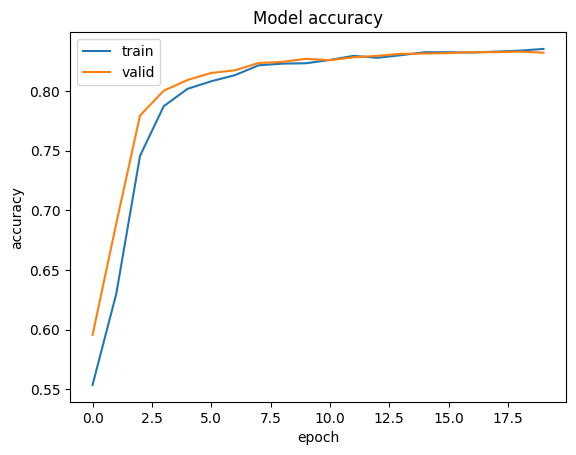

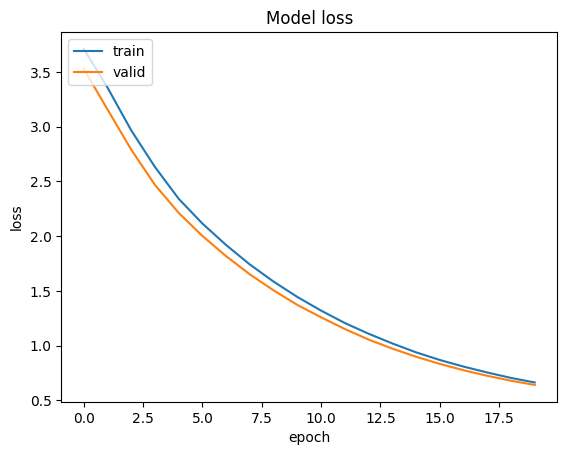

In [ ]:
display_history(history_lstm)

Conclusions:

The final validation accuracy of 83% after over 3 hours of training seems a little lackluster especially when comparing it to the 87% obtained by an instantly trained linear SVM.

However, it is undeniable that LSTMs are one of the best model architectures when dealing with sequences and the main problems here are limited time and computational resources - Google Colab simply does not offer enough runtime for their cloud GPUs, without which the training is unreasonably long.

The main advantage of LSTMs over other presented models is the fact that it is easily up- or downsizable, depending on the available resources and complexity of the problem. Should I have more time and resources, it is very easy to expand the model further, which would most likely be a correct move, as the simple architecture presented did not seem to overfit yet after 20 epochs - the validation accuracy mostly kept increasing, even if at a slower rate.

Another way to improve prediction, but once again, at a cost of computation time, would be to increase the number of words considered by the tokenizer.

Overall, while this particular deployment of an LSTM might not be very impressive, the possibilities of improving it make it worth using if one has enough resources.

Task 3: LSTM with pre-trained SpaCy embeddings

In [12]:
from keras.initializers import Constant
from keras.layers.experimental.preprocessing import TextVectorization

In [13]:
#Downloading and initializing the SpaCy large english model
!python -m spacy download en_core_web_md >> /dev/null
import spacy

nlp = spacy.load('en_core_web_md')

2023-12-22 16:35:59.026084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 16:35:59.026144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 16:35:59.027410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 16:36:00.058741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
#Creating a vectorizing layer to vectorize input words ad-hoc and creating a vocabulary
vectorizing_layer = TextVectorization()
vectorizing_layer.adapt(pd.concat([X_train, X_test]))
vocab = vectorizing_layer.get_vocabulary()
vocab = [str(s) for s in vocab]

In [15]:
#Generating the embedding matrix of size (train ocabulary size, SpaCy embedding dimentions)
embedding_dim_spacy = len(nlp('The').vector)
embedding_matrix = np.zeros((len(vocab), embedding_dim_spacy))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

In [20]:
#Reusing the LSTM architecture from the previous task but with non-trainable, 
#pre-trained embeddings and early stopping
be.clear_session()

callbacks = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)

inputs = Input(shape=(1, ), dtype=tf.string)
vectorizing = vectorizing_layer(inputs)
embedding = Embedding(len(vocab), embedding_dim_spacy, embeddings_initializer=Constant(embedding_matrix), mask_zero=True, trainable=False)(vectorizing)
lstm = LSTM(LSTM_CELL_SIZE, kernel_regularizer='l2', dropout=DROPOUT, recurrent_dropout=DROPOUT)(embedding)
outputs = Dense(2, activation='softmax')(lstm)
model_embed = Model(inputs=inputs, outputs=outputs)

model_embed.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), metrics=['accuracy'])
model_embed.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 300)         54506100  
                                                                 
 lstm (LSTM)                 (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 54907302 (209.45 MB)
Trainable params: 401202 (1.53 MB)
Non-trainable params: 54506100 (207.92 MB)
______________

In [ ]:
history_embed = model_embed.fit(x=X_train, y=y_train,
                                validation_data=(X_test, y_test),
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE//2,
                                callbacks=[callbacks],
                                verbose=1)

Epoch 1/20
313/313 [==============================] - 1263s 4s/step - loss: 4.8461 - accuracy: 0.5238 - val_loss: 4.5630 - val_accuracy: 0.5738
Epoch 2/20
313/313 [==============================] - 1227s 4s/step - loss: 4.3536 - accuracy: 0.5642 - val_loss: 4.1067 - val_accuracy: 0.6084
Epoch 3/20
313/313 [==============================] - 1245s 4s/step - loss: 3.9298 - accuracy: 0.5907 - val_loss: 3.7116 - val_accuracy: 0.6312
Epoch 4/20
313/313 [==============================] - 1230s 4s/step - loss: 3.5619 - accuracy: 0.6128 - val_loss: 3.3683 - val_accuracy: 0.6494
Epoch 5/20
313/313 [==============================] - 1259s 4s/step - loss: 3.2372 - accuracy: 0.6352 - val_loss: 3.0574 - val_accuracy: 0.6785
Epoch 6/20
313/313 [==============================] - 1232s 4s/step - loss: 2.9467 - accuracy: 0.6638 - val_loss: 2.7571 - val_accuracy: 0.7286
Epoch 7/20
313/313 [==============================] - 1233s 4s/step - loss: 2.6529 - accuracy: 0.7278 - val_loss: 2.5139 - val_accuracy:

In [ ]:
display_history(history_embed)

Conclusions:

(Note: I used 3 different Google accounts to get enough free GPU runtime to get all of these models to work, I run out of everything on this last model, but it is clear that the trajectory of validation accuracy is good enough to assume that it would reach higher than 83%, which is the accuracy of the previous LSTM)

LSTM architecture with pretrained word embeddings appeared to perform better than regular LSTM in the given task, with validation accuracy most likely above 83%.

As SpaCy word embeddings, which use the Word2Vec methodology, are generally reliable and were created using methods which are difficult to replicate with a simple tokenizer and embedding layer, it is expected that the results of an LSTM with it would be better than that of a regular one. However, it is surpisingly at a cost of slower convergence, with the validation accuracy entering into 83% territory only on 17th epoch, but with better accuracy gains on later epochs when compared to the precious model, which promises better results in further epochs before overfitting.

The general architecture is virtually unchanged, which means that the negatives and positives as well as possibilities to improve the model are the same.

Two extra challenges which appeared with the pretrained embeddings LSTM are:

1. Higher memory requirement - leaving batch size at previously determined 160 caused an Out-Of-Memory problem. The batch size was cut in half to alleviate it.
2. Including the vectorizing layer into the model itself increased the training time nearly twice, despite the fixed, non-trainable embedding layer weights, which should theoretically improve the training time.

The reason why I decided to include a vectorizing layer dircetly into the model is because when I tried other approaches to using pretraining weights, very often the model would struggle to break the 50% training accuracy threshold within the first few epochs when the tokenizing and vectorizing was done beforehand, like in the first LSTM task. I am unsure as to why this happens and why including the vectorizing layer into the model fixes it.

Task 4: fastText model

In [ ]:
!pip install fasttext >> /dev/null

In [ ]:
train_data['label'] = '__label__' + train_data['sentiment'].astype(str)

#Concatenating label and review text
train_data_ft = train_data[['label', 'text']].apply(lambda x: ' '.join(x), axis=1)

#Saveing formatted data to a text file
train_data_ft.to_csv('train_data_ft.txt', index=False, header=False)

#Removing all quotation marks 
#(Some reviews have quotation marks around them some do not, I am really not sure why)
with open('train_data_ft.txt', 'r') as file:
    content = file.read()
content_without_quotes = content.replace('"', '')
with open('train_data_ft.txt', 'w') as file:
    file.write(content_without_quotes)

#Repating for test data
test_data['label'] = '__label__' + test_data['sentiment'].astype(str)
test_data_ft = test_data[['label', 'text']].apply(lambda x: ' '.join(x), axis=1)
test_data_ft.to_csv('test_data_ft.txt', index=False, header=False)

with open('test_data_ft.txt', 'r') as file:
    content = file.read()
content_without_quotes = content.replace('"', '')
with open('test_data_ft.txt', 'w') as file:
    file.write(content_without_quotes)

In [ ]:
#Creating a validation dataset, so as not to overfit hyperparameters during tuning
with open('test_data_ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Splitting the lines into two equal parts
total_lines = len(lines)
half_lines = total_lines // 2

first_half = lines[:half_lines]
second_half = lines[half_lines:]

# Writing the first part to a validation dataset and second part to testing dataset
with open('valid_data_ft.txt', 'w', encoding='utf-8') as file:
    file.writelines(first_half)

with open('test_data_ft.txt', 'w', encoding='utf-8') as file:
    file.writelines(second_half)

In [ ]:
import fasttext

#Training FastText model and tuning hyperparameters using the validation data.
#Unfortunately, trying to maximize accuracy instead of f1 score crashes Google Collab, 
#thus default f1 will be used for evaluation
model_ft = fasttext.train_supervised(input="train_data_ft.txt", autotuneValidationFile='valid_data_ft.txt')


In [ ]:
#Calculating f1 score for the testing dataset
res = model_ft.test("test_data_ft.txt")
f1=2/((1/res[1])+(1/res[2]))
print(f1)

0.87392


Conclusions:

As mentioned before, I was unable to obtain accuracy score from the Fast Text model. However, as the dataset is balanced, it can be assumed that the accuracy score would be on a similar level as the f1 score, which means that the model performs reasonably well at 87%.

Thanks to employment of subword embeddings, Fast Text models exceed at dealing with OOV tokens, which in the case of our dataset, if we consider all of the tokens from all datasets, can be a problem if left unchecked as the test set contains many tokens which did not appear in the train set.

Another advantage of Fast Text is the fact, that the data preprocessing can be handled mostly on .txt level, which makes it very quick and intuitive. If one collects data with using Fast Text in mind, nearly all preprocessing can be avoided, as the whole process of tokenization and vectorization is handled by the model itself.

Moreover, the hyperparameter tuning process can also be easily automated by the model as well. All these conveniences make the Fast Text model a quick plug-and-play option which does not require multiple steps to make it work properly.

The training time is also acceptable, which makes Fast Text the most convenient model here, when compared to worse-performing linear SVM and LSTMs with much longer training times and more tedious data preparation steps.

The main disadvantage is the fact that the validation output contains only Recall and Precision, which are not optimal metrics for many tasks, such as Sentiment Analysis. However, with a balanced dataset, this is not a very severe issue.





Task 5: Fine-tuned BERT

In [ ]:
!pip install transformers >> /dev/null

In [ ]:
from transformers import AutoTokenizer, TFBertForSequenceClassification, BertTokenizer
from transformers import InputExample, InputFeatures
from tqdm import tqdm

#Instantiating pretrained BERT model for sequence classification and BERT tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Tokenizing training and testing dataset, padding it to maximum length acceptable by BERT (512), 
#transforming them into tensorflow tensors and adding attnetion masks to be used while training
X_train_bert = tokenizer_bert(
    text=train_data['text'].tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test_bert = tokenizer_bert(
    text=test_data['text'].tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
from tensorflow.keras.metrics import categorical_crossentropy

#Creating a BERT model architecture without any extra layers on top of the BERT output
be.clear_session()

input_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

model_bert = bert_model

model_bert.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_bert = model_bert.fit(x = {'input_ids':X_train_bert['input_ids'], 
                                   'attention_mask':X_train_bert['attention_mask']},
                    y = train_data['sentiment'],
                    validation_data = ({'input_ids':X_test_bert['input_ids'], 
                                        'attention_mask':X_test_bert['attention_mask']},
                                       test_data['sentiment']),
                    epochs=2,
                    batch_size=8)

Epoch 1/2
3125/3125 [==============================] - 4060s 1s/step - loss: 0.2231 - accuracy: 0.9120 - val_loss: 0.1645 - val_accuracy: 0.9388
Epoch 2/2
3125/3125 [==============================] - 4050s 1s/step - loss: 0.1150 - accuracy: 0.9604 - val_loss: 0.1883 - val_accuracy: 0.9388


Conclusions:

As a pretrained model, massive enough to cause Out-Of-Memory error in Colab unless a very low batch size is used, it is expected that BERT would have the best results so far, with validation accuracy of 93.9%.

BERT contextual embeddings and pretrained model so far provided the best results when also taking into account the amount of code and time to train. The training time was longer than FastText but also provided sigificantly better results. When comparing to LSTMs, the training was shorter and also yielded better outcome.

The biggest disadvantage of using BERT, which is not completely a disatvantage, just a limitation of the pretrained architecture, is that without adding extra layers on top of the standard BERT model, which would have to be designed specifically to improve an already impressive model, it is virtually impossible to improve the results. Already on second epoch, the model starts to overfit which indicates that basic BERT is not able to get higher than 93.9% on this specific task.

Task 6: Fine-tuned XLNet

In [ ]:
!pip install SentencePiece
#Restart runtime after installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [ ]:
import sentencepiece
from transformers import TFXLNetModel, XLNetTokenizer, TFXLNetForSequenceClassification

#Instantiating pretrained XLNet tokenizer
tokenizer_xl = XLNetTokenizer.from_pretrained('xlnet-base-cased')

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
#Repeating the same process for XLNet as for BERT previously
X_train_xl = tokenizer_xl(
    text=train_data['text'].tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test_xl = tokenizer_xl(
    text=test_data['text'].tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
be.clear_session()

#Preparing the same model architecture as for BERT but for XLNet
input_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

model_xl = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

model_xl.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model_xl.summary()

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

Model: "tfxl_net_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLa  multiple                  116718336 
 yer)                                                            
                                                                 
 sequence_summary (TFSequen  multiple                  590592    
 ceSummary)                                                      
                                                                 
 logits_proj (Dense)         multiple                  1538      
                                                                 
Total params: 117310466 (447.50 MB)
Trainable params: 117310466 (447.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_xl = model_xl.fit(x = {'input_ids':X_train_xl['input_ids'], 
                               'attention_mask':X_train_xl['attention_mask']},
                    y = train_data['sentiment'],
                    validation_data = ({'input_ids':X_test_xl['input_ids'], 
                                        'attention_mask':X_test_xl['attention_mask']}, 
                                       test_data['sentiment']),
                    epochs=2,
                    batch_size=8)

Epoch 1/2
3125/3125 [==============================] - 8336s 3s/step - loss: 0.1866 - accuracy: 0.9303 - val_loss: 0.1473 - val_accuracy: 0.9456
Epoch 2/2
3125/3125 [==============================] - 8333s 3s/step - loss: 0.1129 - accuracy: 0.9598 - val_loss: 0.1500 - val_accuracy: 0.9450


Conclusions:

Like BERT, XLNet is transformer-based and when using its instance from the same package, its usage is virtually the same as BERT and it shares the same strenghts and weaknesses - high performance, simple implementation at a cost of memory requirements and inability to improve results without very specific downstream task layers. However, due to the architecture being even more complicated, it trains about twice as long but also achieves 0.6% better results.